This code generates several scenarios that may be encountered in real life.

0. All nodes honest

1. One node misreports its coordinates while reporting (self-contradictory) accurate distances
2. One node misreports its coordinates while reporting false distances that match the false coordinates
3. One node misreports its distances to peers while reporting accurate coordinates
4. One node claims to be in a location it is not, and no other nodes can see it. It does not provide fake distances to its "neighbors".
5. One node claims to be in a location it is not, and no other nodes can see it. It provides fake distances to it's "neighbors".
6. A group of nodes claim to be in a location they are not, and no other nodes can see them. They do not provide fake distances to their "neighbors".
7. A group of nodes claim to be in a location they are not, and no other nodes can see them. They provide fake distances to their "neighbors".
8. Two nodes collude- one node is totally honest, except for the fact that it confirms dishonest metrics from another.
9. A group of nodes do the above
10. One node misreports its coordinates, misreports its own measurements to other nodes, and manipulates its responses to other nodes by delaying them and looking like it is further away from them than it really is

Output: 
- A $n \times n$ distances matrix $D$ where $D_{ij}$ is $i$'s  measurement of $j$, and vice versa.
- A $n \times 2$ coordinates matrix $C$ where $C_i$ is $[ x, y ]$ for node $i$

This data will contain the falsehoods injected by the dishonest nodes. In real life this data will be collected as submissions of peer measurements and coordinates from each node, but since they will probably be analyzed in this format, we will skip the round trip into the wire format.

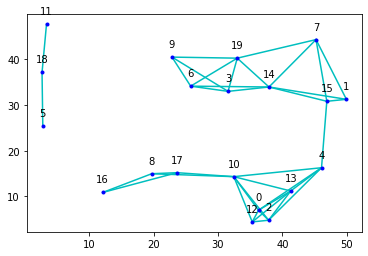

In [4]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt

np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180

FIELD_SIZE = 50
NUM_NODES = 20
MAX_DISTANCE = 15

def plotm(m):
    plt.imshow(m)
    plt.show()

def generate_points():
#     xy = np.random.normal(0.5, 0.25, size=(2, numNodes)) * fieldSize
    xy = np.random.uniform(size=(2, NUM_NODES)) * FIELD_SIZE
    points = np.column_stack(xy)
    return points

def plot_points(points):
    # Put data in format preffered by plot
    xy = np.array([points[0:, 0], points[0:, 1]])
    
    # plot connections
    kdTree = spatial.cKDTree(points)
    pairs = list(kdTree.query_pairs(MAX_DISTANCE))

    def connectpoints(x,y,p1,p2):
        x1, x2 = x[p1], x[p2]
        y1, y2 = y[p1], y[p2]
        plt.plot([x1,x2],[y1,y2],'c-')

    for i in pairs:
        connectpoints(xy[0], xy[1], i[0], i[1])
    
    # plot points
    plt.plot(xy[0], xy[1], 'b.')
    
    # plot labels
    label = 0
    for x, y in zip(xy[0], xy[1]):
        plt.annotate(label, # this is the text
                     (x, y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
        label = label + 1

def make_dist_matrix(points, randomize=False):
    kdTree = spatial.cKDTree(points)
    dists = kdTree.sparse_distance_matrix(kdTree, MAX_DISTANCE)
    dists = dists.toarray()
    
    # Randomize distances matrix (or not)
    if randomize: 
        dists = dists * np.random.normal(1, 0.1, dists.shape)
        
    return dists

def make_honest():
    C = generate_points()
    D = make_dist_matrix(C)
    plot_points(C)
    
    return (C, D)

honest = make_honest()

plt.show()

dishonest index: 15
honest coordinates: [46.90883446 30.79072189]
dishonest coordinates: [44.24878963 31.14018116]


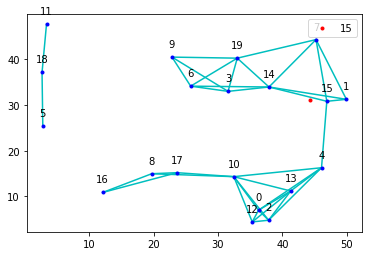

In [6]:
# 1. One node misreports its coordinates while reporting (self-contradictory) accurate distances
def make_dishonest1(C, D, minpeer=3, dishonesty=0.1):
    _C = np.copy(C)
    _D = np.copy(D)
    
    # Choose random node with more than minpeer peers
    nz = np.count_nonzero(_D, axis=1)
    nz = np.where(nz >= minpeer)[0]
    i = nz[np.random.randint(0, nz.size)]
    
    # Offset node by random offsets scaled to field size and desired amount of dishonesty
    xrand = FIELD_SIZE * np.random.normal(0, dishonesty)
    yrand = FIELD_SIZE * np.random.normal(0, dishonesty)
    _C[i] = np.array([_C[i][0] + xrand, _C[i][1] + yrand])
    
    print("dishonest index:", i)
    print("honest coordinates:", C[i])
    print("dishonest coordinates:", _C[i])
    
    plot_points(C)
    plt.plot(_C[i][0], _C[i][1], 'r.', label=i)
    plt.legend()
    plt.show()

    return (_C, _D, i)

dishonest1 = make_dishonest1(*honest)

plt.show()


dishonest index: 17
honest coordinates: [23.64725851 15.16593421]
dishonest coordinates: [17.19821292 16.66007447]


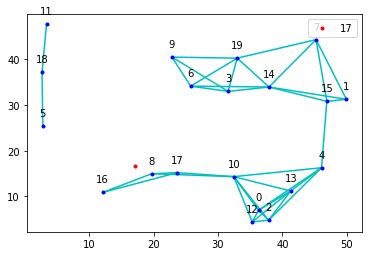

honest distances: [ 0.          0.          0.          0.          0.          0.
  0.          0.          3.93510473  0.          8.86008096  0.
  0.          0.          0.          0.         12.32816131  0.
  0.          0.        ]
dishonest distances: [0.         0.         0.         0.         0.         0.
 0.         0.         3.05272858 0.         0.         0.
 0.         0.         0.         0.         7.73922699 0.
 0.         0.        ]


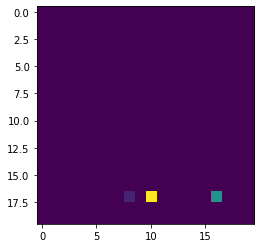

In [7]:
# 2. One node misreports its coordinates while reporting false distances that match the false coordinates
def make_dishonest2(C, D, minpeer=3, dishonesty=0.1):
    (_C, _D, i) = make_dishonest1(C, D, minpeer, dishonesty)
    
    # Generate distances for dishonest node with fake coordinates
    _D[i] = make_dist_matrix(_C)[i]
    
    print("honest distances:", D[i])
    print("dishonest distances:", _D[i])
    
    plt.imshow(D - _D)
    plt.show()
    
    return (_C, _D, i)

dishonest2 = make_dishonest2(*honest)

dishonest index: 19
honest coordinates: [33.00085955 40.22927706]
dishonest coordinates: [33.3024191  33.68636662]


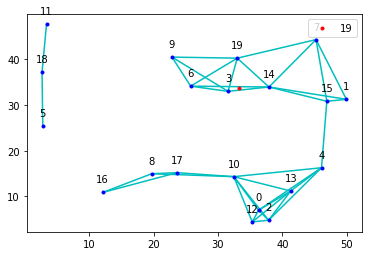

honest distances: [ 0.          0.          0.          7.40355905  0.          0.
  9.47840439 12.8884548   0.         10.13284409  0.          0.
  0.          0.          8.00600966  0.          0.          0.
  0.          0.        ]
dishonest distances: [ 0.          0.          0.          1.87076389  0.          0.
  7.54525944  0.          0.         12.43803699  0.          0.
  0.          0.          4.63430713 13.91112135  0.          0.
  0.          0.        ]


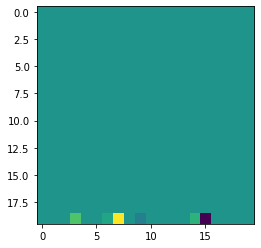

In [8]:
# One node misreports its distances to peers while reporting accurate coordinates
def make_dishonest3(C, D, minpeer=3, dishonesty=0.1):
    (_C, _D, i) = make_dishonest1(C, D, minpeer, dishonesty)
    
    # Generate distances for dishonest node with fake coordinates
    _D[i] = make_dist_matrix(_C)[i]
    
    print("honest distances:", D[i])
    print("dishonest distances:", _D[i])
    
    plt.imshow(D - _D)
    plt.show()
    
    # We return C, which has the real coordinates
    return (C, _D, i)

dishonest3 = make_dishonest3(*honest)

dishonest index: 3
honest coordinates: [31.57675771 32.96397455]
dishonest coordinates: [35.728465   37.42955103]


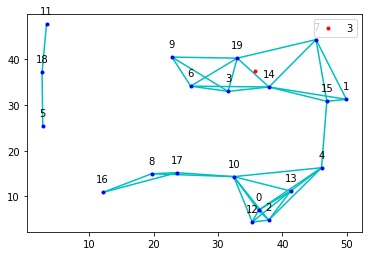

dishonest distances: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


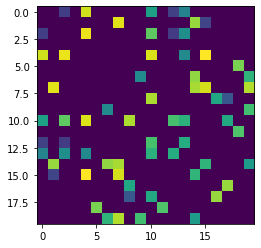

In [10]:
# 4. One node claims to be in a location it is not, and no other nodes can see it.
# It does not provide fake distances to its neighbors.
def make_dishonest4(C, D, minpeer=3, dishonesty=0.1):
    (_C, _D, i) = make_dishonest1(C, D, minpeer, dishonesty)
    
    old = np.copy(_D)
    # Erase other's distances for dishonest node with fake coordinates
    _D[i] = np.zeros(_D[i].shape)
    # Erase measurements of others from dishonest node with fake coordinates
    _D[0:, i] = np.zeros(_D[0:, i].shape)
    
    print("dishonest distances:", _D[i])
    
    plt.imshow(_D)
    plt.show()
    
    return (_C, _D, i)
    
dishonest4 = make_dishonest4(*honest)

dishonest index: 10
honest coordinates: [32.46444839 14.29518903]
dishonest coordinates: [33.34803334 14.52263826]


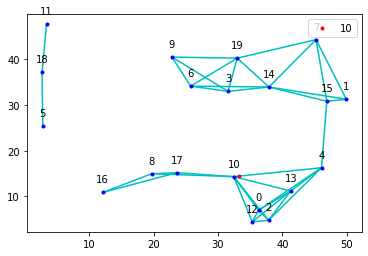

dishonest distances: [ 8.28671317  0.         10.96010268  0.         13.7605665   0.
  0.          0.         12.76187401  0.          0.          0.
 10.31118915  9.37839134  0.          0.          0.          8.86008096
  0.          0.        ]


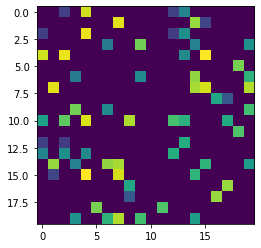

In [12]:
# 5. One node claims to be in a location it is not, and no other nodes can see it.
# It provides fake distances to it's "neighbors".
def make_dishonest5(C, D, minpeer=3, dishonesty=0.1):
    (_C, _D, i) = make_dishonest1(C, D, minpeer, dishonesty)
    
    # Erase distances for dishonest node with fake coordinates
    old = np.copy(_D)
    _D[0:, i] = np.zeros(_D[0:, i].shape)
    
    print("dishonest distances:", _D[i])
    
    plt.imshow(_D)
    plt.show()
    
    return (_C, _D, i)
    
dishonest5 = make_dishonest5(*honest)

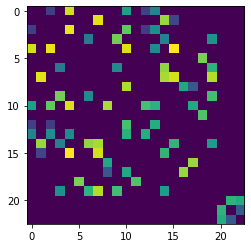

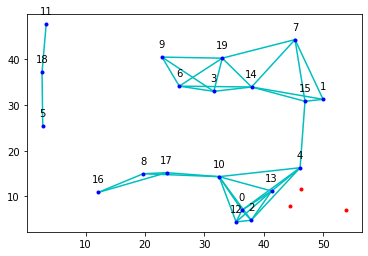

In [15]:
# A group of nodes claim to be in a location they are not, and no other nodes can see them. 
# They do not provide fake distances to their "neighbors".
def make_dishonest6(C, D, minpeer=3, dishonesty=0.1, num=1):
    # Choose random node with more than minpeer peers
    nz = np.count_nonzero(D, axis=1)
    nz = np.where(nz >= minpeer)[0]
    i = nz[np.random.randint(0, nz.size)]
    
    # Make new nodes with random offsets from chosen node, scaled to field size and
    # desired amount of dishonesty
    rand = FIELD_SIZE * np.random.normal(0, dishonesty, size=[num, 2])
    newnodes = rand + C[i]
    _C = np.append(C, newnodes, axis=0)

    # Make distances matrix for old and new nodes
    _D = make_dist_matrix(_C)
    
    dlen = C.shape[0]
    # Delete real node's references to fake nodes
    _D[0:dlen, dlen:] = 0
    # Delete fake node's references to real nodes
    _D[dlen:, 0:dlen] = 0
    
    plotm(_D)
    
    plot_points(C)
    plt.plot(newnodes[0:, 0], newnodes[0:, 1], 'r.')
    plt.show()
    
    return (_C, _D, i)

dishonest6 = make_dishonest6(*honest, num=3)

plt.show()


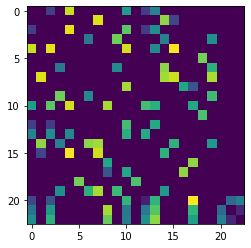

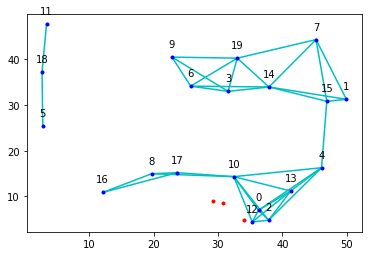

In [16]:
# A group of nodes claim to be in a location they are not, and no other nodes can see them. 
# They provide fake distances to their "neighbors".
def make_dishonest7(C, D, minpeer=3, dishonesty=0.1, num=1):
    # Choose random node with more than minpeer peers
    nz = np.count_nonzero(D, axis=1)
    nz = np.where(nz >= minpeer)[0]
    i = nz[np.random.randint(0, nz.size)]
    
    # Make new nodes with random offsets from chosen node, scaled to field size and
    # desired amount of dishonesty
    rand = FIELD_SIZE * np.random.normal(0, dishonesty, size=[num, 2])
    newnodes = rand + C[i]
    _C = np.append(C, newnodes, axis=0)

    # Make distances matrix for old and new nodes
    _D = make_dist_matrix(_C)
    
    # Delete real node's references to fake nodes
    dlen = C.shape[0]
    _D[0:dlen, dlen:] = 0
    
    plotm(_D)
    
    plot_points(C)
    plt.plot(newnodes[0:, 0], newnodes[0:, 1], 'r.')
    plt.show()
    
    return (_C, _D, i)

dishonest7 = make_dishonest7(*honest, num=3)

plt.show()


traitor node: 4


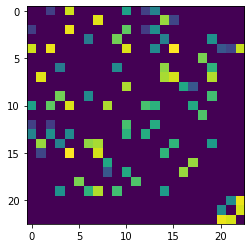

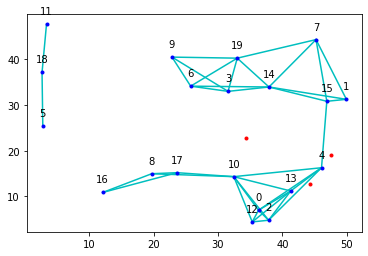

In [17]:
# Two types of nodes collude- traitor nodes exist and interact with honest nodes,
# and confirm dishonest metrics from a group of fake nodes
def make_dishonest8(C, D, minpeer=3, dishonesty=0.1, num=1):
    # Choose random node with more than minpeer peers
    nz = np.count_nonzero(D, axis=1)
    nz = np.where(nz >= minpeer)[0]
    i = nz[np.random.randint(0, nz.size)]
    print("traitor node:", i)
    
    # Make new nodes with random offsets from chosen node, scaled to field size and
    # desired amount of dishonesty
    rand = FIELD_SIZE * np.random.normal(0, dishonesty, size=[num, 2])
    newnodes = rand + C[i]
    _C = np.append(C, newnodes, axis=0)

    # Make distances matrix for old and new nodes
    _D = make_dist_matrix(_C)
    
    # Delete real node's references to fake nodes,
    # and vice versa, but save the traitor node's measurements of fake nodes
    dlen = C.shape[0]
    tnode = _D[i].copy()
    _D[0:dlen, dlen:] = 0
    _D[dlen:, 0:dlen] = 0
    _D[i] = tnode
    
    plotm(_D)
    
    plot_points(C)
    plt.plot(newnodes[0:, 0], newnodes[0:, 1], 'r.')
    plt.show()
    
    return (_C, _D, i)

dishonest8 = make_dishonest8(*honest, num=3)